In [ ]:
try:
  import mat73
except:
  !pip install -q mat73
  import mat73


In [2]:
import os
import numpy as np
from sklearn.utils.extmath import randomized_svd
import matplotlib.pyplot as plt
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import gdown
import time
timestr = time.strftime("%Y-%m-%d_%H.%M.%S")

# DEFINE NECESSARY FUNCTIONS FOR PERFORMING HOSVD

In [3]:
def unfold(A,dim):
    '''Turns tensor into matrix keeping the columns on dim'''
    ax=np.arange(A.ndim)
    return np.reshape(np.moveaxis(A,ax,np.roll(ax,dim)),(A.shape[dim],A.size//A.shape[dim]))


def fold(B,dim,shape):
    '''Reverse operation to the unfold function'''
    ax=np.arange(len(shape))
    shape=np.roll(shape,-dim)
    A=np.reshape(B,shape)
    return np.moveaxis(A,ax,np.roll(ax,-dim))

def tprod(S,U):
    '''Tensor product of an ndim-array and multiple matrices'''
    T = S
    shap = list(np.shape(S))
    for i in range(0,np.size(U)):
        x = np.count_nonzero(U[0][i])
        if not x==0:
            shap[i] = np.shape(U[0][i])[0]
            H = unfold(T,i)
            T = fold(np.dot(U[0][i],H),i,shap)
    return T

def svdtrunc(A, n):
    '''Truncated svd'''
    U, S, _ = randomized_svd(A, n_components = n)
    return U, S

In [4]:
def HOSVD_function(T,varepsilon1):
    '''Perform hosvd to tensor'''
    P = T.ndim
    U = np.zeros(shape=(1,P), dtype=object)
    UT = np.zeros(shape=(1,P), dtype=object)
    sv = np.zeros(shape=(1,P), dtype=object)
    producto = np.size(T)

    if isinstance(varepsilon1, (list, np.ndarray)):
        n = varepsilon1
    else:
        n = T.shape

    n = list(n)

    for i in range(0,P):
        n[i] = int(np.amin((n[i],producto/n[i])))
        A = unfold(T, i)

        Uaux = []
        # SVD based reduction of the current dimension (i):
        Ui, svi = svdtrunc(A, n[i])

        if n[i] < 2:
            Uaux = np.zeros((np.shape(Ui)[0],2))
            Uaux[:,0] = Ui[:,0]
            U[0][i] = Uaux
        else:
            if isinstance(varepsilon1, (list, np.ndarray)):
                pass
            else:
                count = 0
                for j in range(0,np.shape(svi)[0]):
                    if svi[j]/svi[0]<=varepsilon1:
                        pass
                    else:
                        count = count+1
                n[i] = count
            U[0][i] = Ui[:,0:n[i]]

        UT[0][i] = np.transpose(U[0][i])
        sv[0][i] = svi
    S = tprod(T, UT)
    TT = tprod(S, U)
    return TT, S, U, sv, n

# LOAD AND PROCESS DATA
Here we clone the test case available in our databases of a flow past a 2d cylinder

Comment following line if it is not the first run or you have your own database


In [5]:
gdown.download_folder("https://drive.google.com/drive/folders/1eaL945MC46rwhsft72LE_GtSCl15ugB4", output="./")

print('\nLoading the dataset...')
f = mat73.loadmat('./Test Case/Tensor.mat')
Tensor = f['Tensor']
print('\nDataset loaded!')


Retrieving folder contents


Processing file 1CA9q-RAff409xVOGD2DZtsYLf95BfyGM Tensor.mat
Processing file 1socnlP5vBRpNz9vrUkgUv-54_5RmiAvz X.mat
Processing file 1o1dcqmoDEV6UqtwfdS3i3FafLXX3X5Zb Y.mat


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1CA9q-RAff409xVOGD2DZtsYLf95BfyGM
From (redirected): https://drive.google.com/uc?id=1CA9q-RAff409xVOGD2DZtsYLf95BfyGM&confirm=t&uuid=e5e44407-a20b-412c-bf00-406f6443b3d1
To: /Users/pablolopezsalazar/Documents/Python/Código Colab/Test Case/Tensor.mat
100%|██████████| 99.3M/99.3M [00:11<00:00, 8.97MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1socnlP5vBRpNz9vrUkgUv-54_5RmiAvz
From (redirected): https://drive.google.com/uc?id=1socnlP5vBRpNz9vrUkgUv-54_5RmiAvz&confirm=t&uuid=282955f9-11fc-47fe-bc3f-80e52d70f02f
To: /Users/pablolopezsalazar/Documents/Python/Código Colab/Test Case/X.mat
100%|██████████| 8.23k/8.23k [00:00<00:00, 6.61MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1o1dcqmoDEV6UqtwfdS3i3FafLXX3X5Zb
From (redirected): https://drive.google.com/uc?id=1o1dcqmoDEV6UqtwfdS


Loading the dataset...

Dataset loaded!


# CREATE RANDOM GAPS
Here we create a tensor with random NaN values. This is a toy model, so we can compare with the original

The algorithm is meant to be applied directly to databases with NaN values

In [6]:
A_gappy = Tensor

# Create a random mask with a 20% probability of being NaN
mask = np.random.rand(*np.shape(Tensor)) < 0.2  # 20% of values will be NaN
A_gappy[mask] = np.nan

gap_percentage = (np.sum(np.isnan(A_gappy))/A_gappy.size) * 100  # % of gaps
print(f"Percentage of gaps: {gap_percentage:.2f}%")

Percentage of gaps: 20.00%


# HOSVD

In [7]:
# CALIBRATION

method = 'hosvd'               # SVD for matrices, HOSVD for Tensor
m = 10                       # Number of modes to retain on the reconstruction
decision_1 = 'zeros'         # IMPLEMENTED: 'zeros', 'mean' (both can be used for any type of array),
                             #              'interp_1d' (suitable for arrays),
                             #              'interp_2d' (suitable for matrices, method = 'nearest'),
                             #              'Tensor_interp' (suitable for tensors)

print('\n-----------------------------')
print('Database repairing summary:')
print(f'The method used is: {method}')
print(f'The initial reconstruction is fill the gaps using: {decision_1}')
print(f'The number of svd modes retained in each dimension is: {m}')
print('\n-----------------------------')


-----------------------------
Database repairing summary:
The method used is: hosvd
The initial reconstruction is fill the gaps using: zeros
The number of svd modes retained in each dimension is: 10

-----------------------------


# INITIAL RECONSTRUCTION

In [8]:
N = sum(np.isnan(A_gappy.flatten()))

# Initial reconstruction
print('\nCompleting data. Please wait...')
if decision_1 == 'zeros':
    A0_1 = np.nan_to_num(A_gappy, nan = 0)

elif decision_1 == 'mean':
    A0_1 = np.nan_to_num(A_gappy, nan = 0)
    A0_1 = np.nan_to_num(A_gappy,nan=sum(A0_1.flatten())/(A0_1.size-N))

elif decision_1 == 'interp_1d':
    A0_1 = np.zeros(A_gappy.shape)
    y = np.linspace(0, 1, A_gappy.shape[1])
    for j in range(np.size(A_gappy,1)):
        A_gappycolumn = A_gappy[:,j]
        A0_1[:,j] = np.interp(y, y[np.isfinite(A_gappy[:,j])], A_gappycolumn[np.isfinite(A_gappy[:,j])])

elif decision_1 == 'interp_2d':
    if A_gappy.ndim == 2:
        x = np.linspace(0, 1, A_gappy.shape[0])
        y = np.linspace(0, 1, A_gappy.shape[1])
        xv, yv = np.meshgrid(x, y)
        xnumber = xv[np.isfinite(A_gappy)]
        ynumber = yv[np.isfinite(A_gappy)]
        A0_1 = griddata(np.transpose(np.array([xnumber, ynumber])), A_gappy[np.isfinite(A_gappy)] , (xv, yv), method='linear')

elif decision_1 == 'tensor_interp':

    if A_gappy.ndim == 4:
        shape = A_gappy.shape
        A_gappy_re = np.reshape(A_gappy, (A_gappy.shape[0], A_gappy.shape[1] * A_gappy.shape[2], A_gappy.shape[3]))
        for i in range(A_gappy_re.shape[0]):
            for j in range(A_gappy_re.shape[-1]):
                velocity_values = A_gappy_re[i, :, j]
                nan_mask = np.isnan(velocity_values)

                non_nan_indices = np.where(~nan_mask)[0]

                interpolated_values = griddata(non_nan_indices, velocity_values[~nan_mask], np.arange(A_gappy_re.shape[1]), method='linear')

                A_gappy_re[i, nan_mask, j] = interpolated_values[nan_mask]

        A0_1 = np.reshape(A_gappy_re, shape)

print('Initial reconstruction complete!')


Completing data. Please wait...
Initial reconstruction complete!


# ITERATIVELY PERFORM HOSVD, UPDATING THE VALUE OF THE GAPS

In [9]:
A_s = A0_1.copy()
MSE_gaps = np.zeros(500)

for ii in range(500):
    print(f'\nIteration number: {ii+1}')

    if method == 'svd':
        print('\nPerforming SVD. Please wait...')
        [U,S,V]=np.linalg.svd(A_s)
        print('SVD complete!')
        S = np.diag(S)
        A_reconst = U[:,0:m] @ S[0:m,0:m] @ V[0:m,:]
    elif method == 'hosvd':
        n = m*np.ones(np.shape(A_s.shape))
        print('\nPerforming HOSVD. Please wait...')
        A_reconst = HOSVD_function(A_s,n)[0]
        print('HOSVD complete!')

        MSE_gaps[ii] = np.linalg.norm(A_reconst[np.isnan(A_gappy)]-A_s[np.isnan(A_gappy)])/N

    if (ii>3 and MSE_gaps[ii]>=MSE_gaps[ii-1]) or MSE_gaps[ii]<1e-9:
        break
    else:
        A_s[np.isnan(A_gappy)] = A_reconst[np.isnan(A_gappy)]


Iteration number: 1

Performing HOSVD. Please wait...
HOSVD complete!

Iteration number: 2

Performing HOSVD. Please wait...
HOSVD complete!

Iteration number: 3

Performing HOSVD. Please wait...
HOSVD complete!

Iteration number: 4

Performing HOSVD. Please wait...
HOSVD complete!

Iteration number: 5

Performing HOSVD. Please wait...
HOSVD complete!

Iteration number: 6

Performing HOSVD. Please wait...
HOSVD complete!

Iteration number: 7

Performing HOSVD. Please wait...
HOSVD complete!

Iteration number: 8

Performing HOSVD. Please wait...
HOSVD complete!

Iteration number: 9

Performing HOSVD. Please wait...
HOSVD complete!

Iteration number: 10

Performing HOSVD. Please wait...
HOSVD complete!


# PLOTS

Plot singular values


Plotting singular values decay

Performing HOSVD. Please wait...
HOSVD complete!



/var/folders/7j/kcyj8x3j2b5_j6p2jr6h_ltw0000gn/T/ipykernel_24375/3553315914.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('jet')


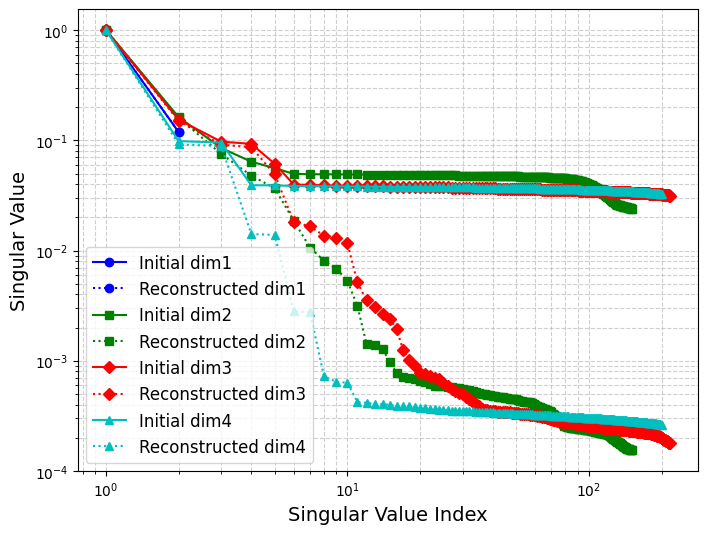

In [10]:
markers = ['o', 's', 'D', '^', 'v', 'p', '*', 'h', 'x', '+']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']

num_dims = Tensor.ndim  # Number of dimensions

fig_sv = plt.figure(figsize=(8, 6))  # Set figure size

print('\nPlotting singular values decay')

if method =='svd':
    print('\nPerforming SVD. Please wait...')
    [U0,S0,V0]=np.linalg.svd(A0_1)
    [U,S,V]=np.linalg.svd(A_s)
    print('SVD complete!\n')
    plt.plot(S0/S0[0],'kx', label="Initial")
    plt.plot(S/S[0],'rx', label="Reconstructed")

elif method == 'hosvd':
    print('\nPerforming HOSVD. Please wait...')
    sv0 = HOSVD_function(A0_1,np.array(A0_1.shape))[3]
    sv =  HOSVD_function(A_s,np.array(A_s.shape))[3]
    print('HOSVD complete!\n')
    cmap = plt.cm.get_cmap('jet')
    rgba = cmap(np.linspace(0,1,num_dims))
    for i in range(num_dims):
        s = sv[0,i]
        s = s/np.max(s)
        s1 = sv0[0,i]
        s1 = s1/np.max(s1)
        plt.plot(
		range(1, len(s) + 1), s1,  # Singular values of each dimension
		marker=markers[i % len(markers)], color=colors[i % len(colors)],
		linestyle='-', linewidth=1.5, markersize=6, label=f"Initial dim{i+1}"
		)

        plt.plot(range(1, len(s) + 1), s,marker=markers[i % len(markers)], color=colors[i % len(colors)],
		linestyle=':', linewidth=1.5, markersize=6, label=f"Reconstructed dim{i+1}")

plt.xlabel("Singular Value Index", fontsize=14)
plt.ylabel("Singular Value", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, which="both", linestyle="--", alpha=0.6)
plt.xscale("log")  # Log scale for index
plt.yscale("log")  # Log scale for singular values
plt.gca().spines["top"].set_visible(True)
plt.gca().spines["right"].set_visible(True)

plt.show()

Plot original vs enhanced reconstruction

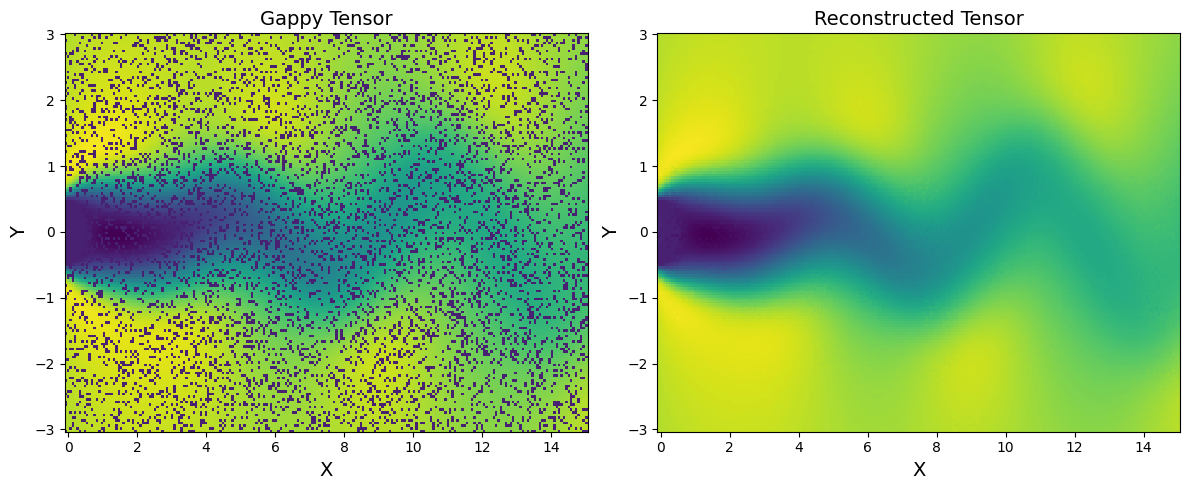

In [11]:
# Plot original vs reconstruction
f = mat73.loadmat('./Test Case/X.mat')
X = f['X']
f = mat73.loadmat('./Test Case/Y.mat')
Y = f['Y']

component = 0  # First component
original_slice = A0_1[component, :, :, -1]
reconstructed_slice = A_s[component, :, :,-1]

vmin, vmax = min(original_slice.min(), reconstructed_slice.min()), max(original_slice.max(), reconstructed_slice.max())

fig_rec, axes_rec = plt.subplots(1, 2, figsize=(12, 5))

# Plot original tensor
im1 = axes_rec[0].pcolor(X,Y,original_slice, cmap="viridis", shading="auto", vmin=vmin, vmax=vmax)
axes_rec[0].set_title("Gappy Tensor", fontsize=14)
axes_rec[0].set_xlabel("X", fontsize=14)
axes_rec[0].set_ylabel("Y", fontsize=14)

# Plot reconstructed tensor
im2 = axes_rec[1].pcolor(X,Y,reconstructed_slice, cmap="viridis", shading="auto", vmin=vmin, vmax=vmax)
axes_rec[1].set_title("Reconstructed Tensor", fontsize=14)
axes_rec[1].set_xlabel("X", fontsize=14)
axes_rec[1].set_ylabel("Y", fontsize=14)

plt.tight_layout()
plt.show()